<a href="https://colab.research.google.com/github/PUBPOL-2130/notebooks/blob/main/future/CVAP_turnout_MA12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install maup census
!curl -OL https://github.com/PUBPOL-2130/notebooks/raw/refs/heads/main/data/25_block_2010_P3.zip
!unzip 25_block_2010_P3.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2740k  100 2740k    0     0  3091k      0 --:--:-- --:--:-- --:--:-- 3091k
Archive:  25_block_2010_P3.zip
  inflating: 25_block_2010_P3.csv    


# Using Maup to Put Real CVAP and Election Data together

In [2]:
from census import Census
import pandas as pd
import numpy as np
import geopandas as gpd
import maup

maup.progress.enabled = True

census = Census("", year=2010)

choropleth_style = dict(
    edgecolor="0.1",
    linewidth=0.2,
    cmap="Blues",
    legend=True,
    legend_kwds={'shrink': 0.4},
)

# Preparing the Election Data

The first thing that we need to do is to get some election data! We will be using the
2012 General election data from MA in this tutorial notebook because MA is one of the few
states that publishes precinct shapefiles and election data.

To get the shapefile for this project, we will need to go to the
[Massachusetts GIS Website](https://www.mass.gov/info-details/massgis-data-layers)
and download the appropriate file for working with 2012 data (the file will be named
"wardsprecincts_poly.zip" when you find it.)

In [3]:
ma_ward_precinct_gdf = gpd.read_file("https://s3.us-east-1.amazonaws.com/download.massgis.digital.mass.gov/shapefiles/state/wardsprecincts_poly.zip")

In [4]:
ma_ward_precinct_gdf["TOWN"] = ma_ward_precinct_gdf["TOWN"].map(lambda x: x.title())
ma_ward_precinct_gdf = ma_ward_precinct_gdf[["TOWN", "WARD", "PRECINCT", "DISTRICT", "geometry"]]
ma_ward_precinct_gdf.rename(columns={"DISTRICT": "VTD"}, inplace=True)
ma_ward_precinct_gdf

,TOWN,WARD,PRECINCT,VTD,geometry
0,Braintree,None,5B,5B,"POLYGON ((242364.517 883741.979, 242359.642 88..."
1,Braintree,None,6A,6A,"POLYGON ((243479.798 881994.897, 243477.538 88..."
2,Braintree,None,6B,6B,"POLYGON ((241614.364 881551.551, 241602.936 88..."
3,Chelsea,1,1,1-1,"POLYGON ((239281.036 904133.287, 239277.513 90..."
4,Chelsea,1,2,1-2,"POLYGON ((238408.578 904480.138, 238393.140 90..."
...,...,...,...,...,...
2147,Boston,7,8,7-8,"POLYGON ((236328.257 897806.825, 236339.793 89..."
2148,Boston,12,3,12-3,"POLYGON ((234387.165 896770.015, 234357.873 89..."
2149,Boston,12,2,12-2,"POLYGON ((234109.165 896499.623, 234101.151 89..."
2150,Boston,11,2,11-2,"POLYGON ((233908.714 896981.859, 233743.883 89..."


Since the geometry is uniquely identified by the combination of the Town, Ward, and Precinct,
we're going to make a column containing this information so that we can use it as an index
later when we want to add election data.

In [5]:
ma_ward_precinct_gdf["Name"] = (
    ma_ward_precinct_gdf["TOWN"] +
    " Ward " + ma_ward_precinct_gdf["WARD"].astype(str) +
    " Precinct " + ma_ward_precinct_gdf["PRECINCT"].astype(str)
)

# Check to make sure that the Name column has as many unique names as there are
# entries in the dataframe
len(ma_ward_precinct_gdf["Name"].unique()) == len(ma_ward_precinct_gdf)

True

In [6]:
# Let's just look at the names really quick
ma_ward_precinct_gdf.Name

,Name
0,Braintree Ward None Precinct 5B
1,Braintree Ward None Precinct 6A
2,Braintree Ward None Precinct 6B
3,Chelsea Ward 1 Precinct 1
4,Chelsea Ward 1 Precinct 2
...,...
2147,Boston Ward 7 Precinct 8
2148,Boston Ward 12 Precinct 3
2149,Boston Ward 12 Precinct 2
2150,Boston Ward 11 Precinct 2


Now let's grab the election data. You can find this at the
[Massachusetts Election Data Page](https://electionstats.state.ma.us/elections/)

In [7]:
ma_elec_12_df = pd.read_csv("https://electionstats.state.ma.us/elections/download/112698/precincts_include:1/")
ma_elec_12_df

,City/Town,Ward,Pct,Obama/ Biden,Romney/ Ryan,Johnson/ Gray,Stein/ Honkala,All Others,No Preference,Blanks,Total Votes Cast
0,NaN,NaN,NaN,Democratic,Republican,Libertarian,Green-Rainbow,NaN,NaN,NaN,NaN
1,Abington,-,1,844,705,6,7,4,0.0,5,"1,571"
2,Abington,-,2,742,741,18,8,4,0.0,7,"1,520"
3,Abington,-,3,815,801,13,11,2,0.0,6,"1,648"
4,Abington,-,4,899,904,8,9,5,0.0,5,"1,830"
...,...,...,...,...,...,...,...,...,...,...,...
2171,Yarmouth,-,4,"1,056",909,10,9,2,0.0,15,"2,001"
2172,Yarmouth,-,5,882,810,11,8,0,0.0,8,"1,719"
2173,Yarmouth,-,6,924,826,13,11,2,0.0,7,"1,783"
2174,Yarmouth,-,7,"1,169","1,269",13,11,1,0.0,6,"2,469"


Uh oh, it looks like the nice election data that we got from the state's website doesn't match
up with their shapefile (notice that there are 2176 rows in the election file but only 2152 in
the shapefile)! This is actually **very** common, so let's see if we can figure out what
is going on and if we can work with this data. We'll start by fixing up the data so that the data
types are what we expect, and by making an index column for the election data in the same way
that we did for the precinct data.

In [8]:
# Get rid of the first and last row since they do not follow the same format
# the if statement is so that you can rerun this cell if you want and it won't crash
if ma_elec_12_df.shape[0] == 2176:
    ma_elec_12_df.drop([0, 2175], inplace=True)

ma_elec_12_df.reset_index(drop=True, inplace=True)

# We also need to convert the election columns from strings into integers

columns_to_convert = [ # Names of the columns to convert
    "Obama/ Biden",
    "Romney/ Ryan",
    "Johnson/ Gray",
    "Stein/ Honkala",
    "All Others",
    "Blanks",
    "No Preference",
    "Total Votes Cast"
]

# Convert the columns
for col in columns_to_convert:
    new_col = []
    for val in ma_elec_12_df[col]:
        if isinstance(val, str):
            # get rid of commas and convert to int
            new_val = int(val.replace(",", ""))
        new_col.append(new_val)

    ma_elec_12_df[col] = new_col

# Fix the ward column so that it is consistent with the shapefile's ward column
new_col = []
for ward in ma_elec_12_df["Ward"]:
    if ward == "-":
        new_col.append("None")
    else:
        new_col.append(ward)
ma_elec_12_df["Ward"] = new_col

# Now make the new index column that will uniquely identify each precinct
ma_elec_12_df["Name"] = (
    ma_elec_12_df["City/Town"]
        + " Ward " + ma_elec_12_df["Ward"]
        + " Precinct " + ma_elec_12_df["Pct"].astype(str)
)
len(ma_elec_12_df["Name"].unique()) == ma_elec_12_df.shape[0]

True

In [9]:
# Let's take a look at the Name column to make sure things look like what we expect
ma_elec_12_df.Name

,Name
0,Abington Ward None Precinct 1
1,Abington Ward None Precinct 2
2,Abington Ward None Precinct 3
3,Abington Ward None Precinct 4
4,Abington Ward None Precinct 5
...,...
2169,Yarmouth Ward None Precinct 3
2170,Yarmouth Ward None Precinct 4
2171,Yarmouth Ward None Precinct 5
2172,Yarmouth Ward None Precinct 6


Since we know that the shapefile and the election file do not match up perfectly, we now need to
try and find the discrepancies. We tried to make an index that uniquely identifies a precinct, and
we tried to make these names match between our two files, so let's see how far off the name columns
are in our dataframes.

In [10]:
# Print out the names that are in the election data but not in the ward precinct data
# The "set" function will give you the unique names in the list and subtracting the
# two sets will give you the names that are in the first set but not the second
set(ma_elec_12_df.Name) - set(ma_ward_precinct_gdf.Name)

{'Andover Ward None Precinct 7A',
 'Andover Ward None Precinct 9A',
 'Bellingham Ward None Precinct 4A',
 'Cambridge Ward 3 Precinct 2A',
 'Chicopee Ward 6 Precinct AN',
 'Chicopee Ward 6 Precinct AS',
 'Chicopee Ward 6 Precinct BE',
 'Chicopee Ward 6 Precinct BW',
 'Dracut Ward None Precinct 6A',
 'E. Bridgewater Ward None Precinct 1',
 'E. Bridgewater Ward None Precinct 2',
 'E. Bridgewater Ward None Precinct 3',
 'E. Bridgewater Ward None Precinct 4',
 'E. Brookfield Ward None Precinct 1',
 'E. Longmeadow Ward None Precinct 1',
 'E. Longmeadow Ward None Precinct 2',
 'E. Longmeadow Ward None Precinct 3',
 'E. Longmeadow Ward None Precinct 4',
 'Fall River Ward 5 Precinct B1',
 'Fall River Ward 6 Precinct C1',
 'Hingham Ward None Precinct 5A',
 'Manchester-by-the-Sea Ward None Precinct 1',
 'N. Adams Ward 1 Precinct 1',
 'N. Adams Ward 2 Precinct 2',
 'N. Adams Ward 3 Precinct 3',
 'N. Adams Ward 4 Precinct 4',
 'N. Adams Ward 5 Precinct 5',
 'N. Andover Ward None Precinct 1',
 'N. A

In [11]:
# Print out the names that are in the ward precinct data but not in the election data
set(ma_ward_precinct_gdf.Name) - set(ma_elec_12_df.Name)

{'Chicopee Ward 6 Precinct A',
 'Chicopee Ward 6 Precinct B',
 'East Bridgewater Ward None Precinct 1',
 'East Bridgewater Ward None Precinct 2',
 'East Bridgewater Ward None Precinct 3',
 'East Bridgewater Ward None Precinct 4',
 'East Brookfield Ward None Precinct 1',
 'East Longmeadow Ward None Precinct 1',
 'East Longmeadow Ward None Precinct 2',
 'East Longmeadow Ward None Precinct 3',
 'East Longmeadow Ward None Precinct 4',
 'Manchester Ward None Precinct 1',
 'North Adams Ward 1 Precinct 1',
 'North Adams Ward 2 Precinct 2',
 'North Adams Ward 3 Precinct 3',
 'North Adams Ward 4 Precinct 4',
 'North Adams Ward 5 Precinct 5',
 'North Andover Ward None Precinct 1',
 'North Andover Ward None Precinct 2',
 'North Andover Ward None Precinct 3',
 'North Andover Ward None Precinct 4',
 'North Andover Ward None Precinct 5',
 'North Andover Ward None Precinct 6',
 'North Andover Ward None Precinct 7',
 'North Andover Ward None Precinct 8',
 'North Attleborough Ward None Precinct 1',
 'N

Okay, the very first thing that we can see going wrong is that there are some abbreviations in
the names of the election data file. So, let's go ahead and undo those abbreviations and
check what we are left with.

In [12]:
def fix_city_town(x):
    if "E." in x:
        return x.replace("E. ", "East ")
    elif "W." in x:
        return x.replace("W. ", "West ")
    elif "N." in x:
        return x.replace("N. ", "North ")
    elif "S." in x:
        return x.replace("S. ", "South ")
    return x

# Fix the city/town names
new_city_town = []
for city_town in ma_elec_12_df["City/Town"]:
    new_city_town.append(fix_city_town(city_town))
ma_elec_12_df["City/Town"] = new_city_town

ma_elec_12_df["Name"] = (
    ma_elec_12_df["City/Town"]
    + " Ward " + ma_elec_12_df["Ward"]
    + " Precinct " + ma_elec_12_df["Pct"].astype(str)
)
len(ma_elec_12_df["Name"].unique())

2174

In [13]:
# Print out the names that are in the election data but not in the ward precinct data
set(ma_elec_12_df.Name) - set(ma_ward_precinct_gdf.Name)

{'Andover Ward None Precinct 7A',
 'Andover Ward None Precinct 9A',
 'Bellingham Ward None Precinct 4A',
 'Cambridge Ward 3 Precinct 2A',
 'Chicopee Ward 6 Precinct AN',
 'Chicopee Ward 6 Precinct AS',
 'Chicopee Ward 6 Precinct BE',
 'Chicopee Ward 6 Precinct BW',
 'Dracut Ward None Precinct 6A',
 'Fall River Ward 5 Precinct B1',
 'Fall River Ward 6 Precinct C1',
 'Hingham Ward None Precinct 5A',
 'Manchester-by-the-Sea Ward None Precinct 1',
 'Newburyport Ward 1 Precinct P',
 'Palmer Ward None Precinct 1A',
 'Peabody Ward 4 Precinct 3A',
 'Quincy Ward 2 Precinct 3A',
 'Raynham Ward None Precinct 1A',
 'Raynham Ward None Precinct 2A',
 'Revere Ward 2 Precinct 3A',
 'Revere Ward 5 Precinct 1A',
 'Revere Ward 5 Precinct 2A',
 'Sudbury Ward None Precinct 1A',
 'Warren Ward None Precinct B',
 'Winchendon Ward None Precinct 1A'}

In [14]:
# Print out the names that are in the ward precinct data but not in the election data
set(ma_ward_precinct_gdf.Name) - set(ma_elec_12_df.Name)

{'Chicopee Ward 6 Precinct A',
 'Chicopee Ward 6 Precinct B',
 'Manchester Ward None Precinct 1'}

Much better! We can now see that there are several Precincts in the election data file that are not
in the election data file. Really, we should contact one of the election officials at this point
and ask them how to aggregate this data, but for the purposes of this example, we are going to do
some natural language processing ourselves to get the data ready for use with `maup`.

In [15]:
# Let's see what the valid precinct names for Andover are
[x for x in ma_ward_precinct_gdf.Name if "andover" in x.lower()]

['Andover Ward None Precinct 2',
 'Andover Ward None Precinct 3',
 'Andover Ward None Precinct 1',
 'Andover Ward None Precinct 9',
 'Andover Ward None Precinct 8',
 'Andover Ward None Precinct 7',
 'Andover Ward None Precinct 6',
 'Andover Ward None Precinct 5',
 'Andover Ward None Precinct 4',
 'North Andover Ward None Precinct 7',
 'North Andover Ward None Precinct 6',
 'North Andover Ward None Precinct 4',
 'North Andover Ward None Precinct 1',
 'North Andover Ward None Precinct 2',
 'North Andover Ward None Precinct 3',
 'North Andover Ward None Precinct 5',
 'North Andover Ward None Precinct 8']

Looking at the above printout, we can probably make the assumption that
'Andover Ward None Precinct 7A' in the election data should just be grouped in with
'Andover Ward None Precinct 7'. There are a few other things like this (e.g. the
apparent N/S/E/W division in Chicopee), so let's fix up the names where it's mostly obvious
what we should do.

In [16]:
def fix_name(x):
    fix_dictionary = {
        'Andover Ward None Precinct 7A':"Andover Ward None Precinct 7",
        'Andover Ward None Precinct 9A':"Andover Ward None Precinct 9",
        'Bellingham Ward None Precinct 4A':"Bellingham Ward None Precinct 4",
        'Cambridge Ward 3 Precinct 2A':"Cambridge Ward 3 Precinct 2",
        'Chicopee Ward 6 Precinct AN':"Chicopee Ward 6 Precinct A",
        'Chicopee Ward 6 Precinct AS':"Chicopee Ward 6 Precinct A",
        'Chicopee Ward 6 Precinct BE':"Chicopee Ward 6 Precinct B",
        'Chicopee Ward 6 Precinct BW':"Chicopee Ward 6 Precinct B",
        'Dracut Ward None Precinct 6A':"Dracut Ward None Precinct 6",
        'Fall River Ward 5 Precinct B1':"Fall River Ward 5 Precinct B",
        'Fall River Ward 6 Precinct C1':"Fall River Ward 6 Precinct C",
        'Hingham Ward None Precinct 5A':"Hingham Ward None Precinct 5",
        'Manchester-by-the-Sea Ward None Precinct 1':"Manchester Ward None Precinct 1",
        'Palmer Ward None Precinct 1A':"Palmer Ward None Precinct 1",
        'Peabody Ward 4 Precinct 3A':"Peabody Ward 4 Precinct 3",
        'Quincy Ward 2 Precinct 3A':"Quincy Ward 2 Precinct 3",
        'Raynham Ward None Precinct 1A':"Raynham Ward None Precinct 1",
        'Raynham Ward None Precinct 2A':"Raynham Ward None Precinct 2",
        'Revere Ward 2 Precinct 3A':"Revere Ward 2 Precinct 3",
        'Revere Ward 5 Precinct 1A':"Revere Ward 5 Precinct 1",
        'Revere Ward 5 Precinct 2A':"Revere Ward 5 Precinct 2",
        'Sudbury Ward None Precinct 1A':"Sudbury Ward None Precinct 1",
        'Winchendon Ward None Precinct 1A':"Winchendon Ward None Precinct 1",
    }

    # The dictionary.get(x, y) pattern says "get the value for x in the dictionary if it
    # exists in the keys, otherwise return y"
    return fix_dictionary.get(x, x)


new_name_col = []
for name in ma_elec_12_df["Name"]:
    new_name_col.append(fix_name(name))

ma_elec_12_df["Name"] = new_name_col
len(ma_elec_12_df["Name"].unique())

2154

In [17]:
# Print out the names that are in the election data but not in the ward precinct data
set(ma_elec_12_df.Name) - set(ma_ward_precinct_gdf.Name)

{'Newburyport Ward 1 Precinct P', 'Warren Ward None Precinct B'}

In [18]:
set(ma_ward_precinct_gdf.Name) - set(ma_elec_12_df.Name)

set()

Okay, that's almost everything! Let's take a look at the two remaining weird names and figure out
something sensible to do with them.

In [19]:
# Let's see what the valid precinct names for Warren are
[x for x in ma_ward_precinct_gdf.Name if "warren" in x.lower()]

['Warren Ward None Precinct A']

In [20]:
# And the precinct names according to the election file
[x for x in ma_elec_12_df.Name if "warren" in x.lower()]

['Warren Ward None Precinct A', 'Warren Ward None Precinct B']

In [21]:
# Let's also look at Newburyport in the ward_precinct file really quick
[x for x in ma_ward_precinct_gdf.Name if "newburyport" in x.lower()]

['Newburyport Ward 6 Precinct 1',
 'Newburyport Ward 4 Precinct 1',
 'Newburyport Ward 2 Precinct 1',
 'Newburyport Ward 5 Precinct 1',
 'Newburyport Ward 3 Precinct 1',
 'Newburyport Ward 1 Precinct 1']

So it looks like the best thing to do for now is to assert that the data for Warren Precinct B
can be grouped with Warren Precinct A. For Newburyport, it looks like there should only be one
precinct per ward, so we'll group Precinct P in Ward 1 with Precinct 1 in Ward 1.

In [22]:
def fix_name_part2(x):
    fix_dictionary = {
        'Warren Ward None Precinct B': "Warren Ward None Precinct A",
        'Newburyport Ward 1 Precinct P': "Newburyport Ward 1 Precinct 1",
    }

    return fix_dictionary.get(x, x)


# Make sure to do this AFTER running the first fix_name function
new_name_col = []
for name in ma_elec_12_df["Name"]:
    new_name_col.append(fix_name_part2(name))

ma_elec_12_df["Name"] = new_name_col
len(ma_elec_12_df["Name"].unique())

2152

In [23]:
# Now we sanity-check that the names are the same
set(ma_elec_12_df.Name.unique()) == set(ma_ward_precinct_gdf.Name.unique())

True

Yay! We have sucessfully cleaned the election data! Now we just need to put the election data
onto our geodataframe, and we can move on to getting CVAP data.

In [24]:
# We drop "City/Town", "Ward", and "Pct" because the 'sum' function will end up concatenating
# the names making them invalid, and all of the information that we need is already in the "Name"
# column we are using as the index (note: "Name" is not duplicated because we grouped by it)
condensed_ma_elec_12_df = ma_elec_12_df.groupby("Name").sum().drop(["City/Town", "Ward", "Pct"], axis=1)
condensed_ma_elec_12_df

,Obama/ Biden,Romney/ Ryan,Johnson/ Gray,Stein/ Honkala,All Others,No Preference,Blanks,Total Votes Cast
Name,,,,,,,,
Abington Ward None Precinct 1,844,705,6,7,4,6,5,1571
Abington Ward None Precinct 2,742,741,18,8,4,6,7,1520
Abington Ward None Precinct 3,815,801,13,11,2,6,6,1648
Abington Ward None Precinct 4,899,904,8,9,5,6,5,1830
Abington Ward None Precinct 5,844,910,8,2,5,6,5,1774
...,...,...,...,...,...,...,...,...
Yarmouth Ward None Precinct 3,860,694,11,13,5,6,8,1591
Yarmouth Ward None Precinct 4,1056,909,10,9,2,6,15,2001
Yarmouth Ward None Precinct 5,882,810,11,8,0,6,8,1719


In [25]:
# We set the index to be the "Name" column so that we can use it to merge with the
# condensed_ma_elec_12_df dataframe. Importantly, we now know that these indices are
# the same!!
ma_ward_precinct_gdf.set_index("Name", inplace=True)

In [26]:
ma_ward_precinct_gdf["Dem Votes"] = condensed_ma_elec_12_df["Obama/ Biden"]
ma_ward_precinct_gdf["Rep Votes"] = condensed_ma_elec_12_df["Romney/ Ryan"]
ma_ward_precinct_gdf["Total Votes"] = condensed_ma_elec_12_df["Total Votes Cast"]
ma_ward_precinct_gdf

,TOWN,WARD,PRECINCT,VTD,geometry,Dem Votes,Rep Votes,Total Votes
Name,,,,,,,,
Braintree Ward None Precinct 5B,Braintree,None,5B,5B,"POLYGON ((242364.517 883741.979, 242359.642 88...",857,851,1737
Braintree Ward None Precinct 6A,Braintree,None,6A,6A,"POLYGON ((243479.798 881994.897, 243477.538 88...",916,1035,1981
Braintree Ward None Precinct 6B,Braintree,None,6B,6B,"POLYGON ((241614.364 881551.551, 241602.936 88...",862,823,1729
Chelsea Ward 1 Precinct 1,Chelsea,1,1,1-1,"POLYGON ((239281.036 904133.287, 239277.513 90...",410,93,515
Chelsea Ward 1 Precinct 2,Chelsea,1,2,1-2,"POLYGON ((238408.578 904480.138, 238393.140 90...",255,36,305
...,...,...,...,...,...,...,...,...
Boston Ward 7 Precinct 8,Boston,7,8,7-8,"POLYGON ((236328.257 897806.825, 236339.793 89...",468,191,690
Boston Ward 12 Precinct 3,Boston,12,3,12-3,"POLYGON ((234387.165 896770.015, 234357.873 89...",713,16,734
Boston Ward 12 Precinct 2,Boston,12,2,12-2,"POLYGON ((234109.165 896499.623, 234101.151 89...",1406,13,1425


# Preparing the Geometries

Now that we have election data on precincts, we need to prepare some geographic data. Unfortunately
for us, ACS data, which contains information about CVAP, is only available to the public on the
tract level. This means that we will need to use `maup` to prorate the data down to the block level
before building it back up to the precinct level.

However, before we can even start with the CVAP data, we need to make sure that we have a good
VAP data on blocks that can be meaningfully assigned to the state's precinct geometries!

In [27]:
# this will take some time to finish
ma_2010_census_blocks_gdf = gpd.read_file(
    "https://www2.census.gov/geo/tiger/TIGER2010/TABBLOCK/2010/tl_2010_25_tabblock10.zip"
)

In [28]:
# We set the index to the GEOID10 column since it is the unique identifier for each block geometry
ma_2010_census_blocks_gdf.set_index("GEOID10", inplace=True)
# Before we call maup.assign, we need to make sure the block data and the ward precinct data
# are in the same coordinate reference system (CRS)
ma_2010_census_blocks_gdf.to_crs(ma_ward_precinct_gdf.crs, inplace=True)

In [29]:
block_to_precinct_assignment = maup.assign(
    ma_2010_census_blocks_gdf, ma_ward_precinct_gdf
)

100%|██████████| 2152/2152 [00:26<00:00, 81.03it/s] 


We now have this assignment vector that theoretically assigns each block to a precinct (that is
what the
[maup documentation](https://maup.readthedocs.io/en/latest/user/getting_started/#) says, right?).
So let's take a look and make sure that we have something sensible.

In [30]:
block_to_precinct_assignment

,0
GEOID10,
250010153001070,Barnstable Ward None Precinct 1
250010125022055,Barnstable Ward None Precinct 13
250010127002018,Barnstable Ward None Precinct 4
250010125022026,Barnstable Ward None Precinct 13
250010122003103,Barnstable Ward None Precinct 11
...,...
250277441022027,Milford Ward None Precinct 5
250277441021016,Milford Ward None Precinct 6
250277444002012,Milford Ward None Precinct 6


In [31]:
# Let's just check and make sure that we didn't lose any blocks (assign them to nothing)
block_to_precinct_assignment.isna().sum()

603

Oh no! It looks like our precinct shapefile doesn't cover all of the census blocks! This is
something that we always need to be on the lookout for since those missing blocks might have
people that we would like to count in them. Let's take a look and see what has gone wrong here.

In [32]:
# We will need this column to help us graph things more easily, and it will help us
# filter out bad assignments later
ma_2010_census_blocks_gdf["assignment"] = block_to_precinct_assignment

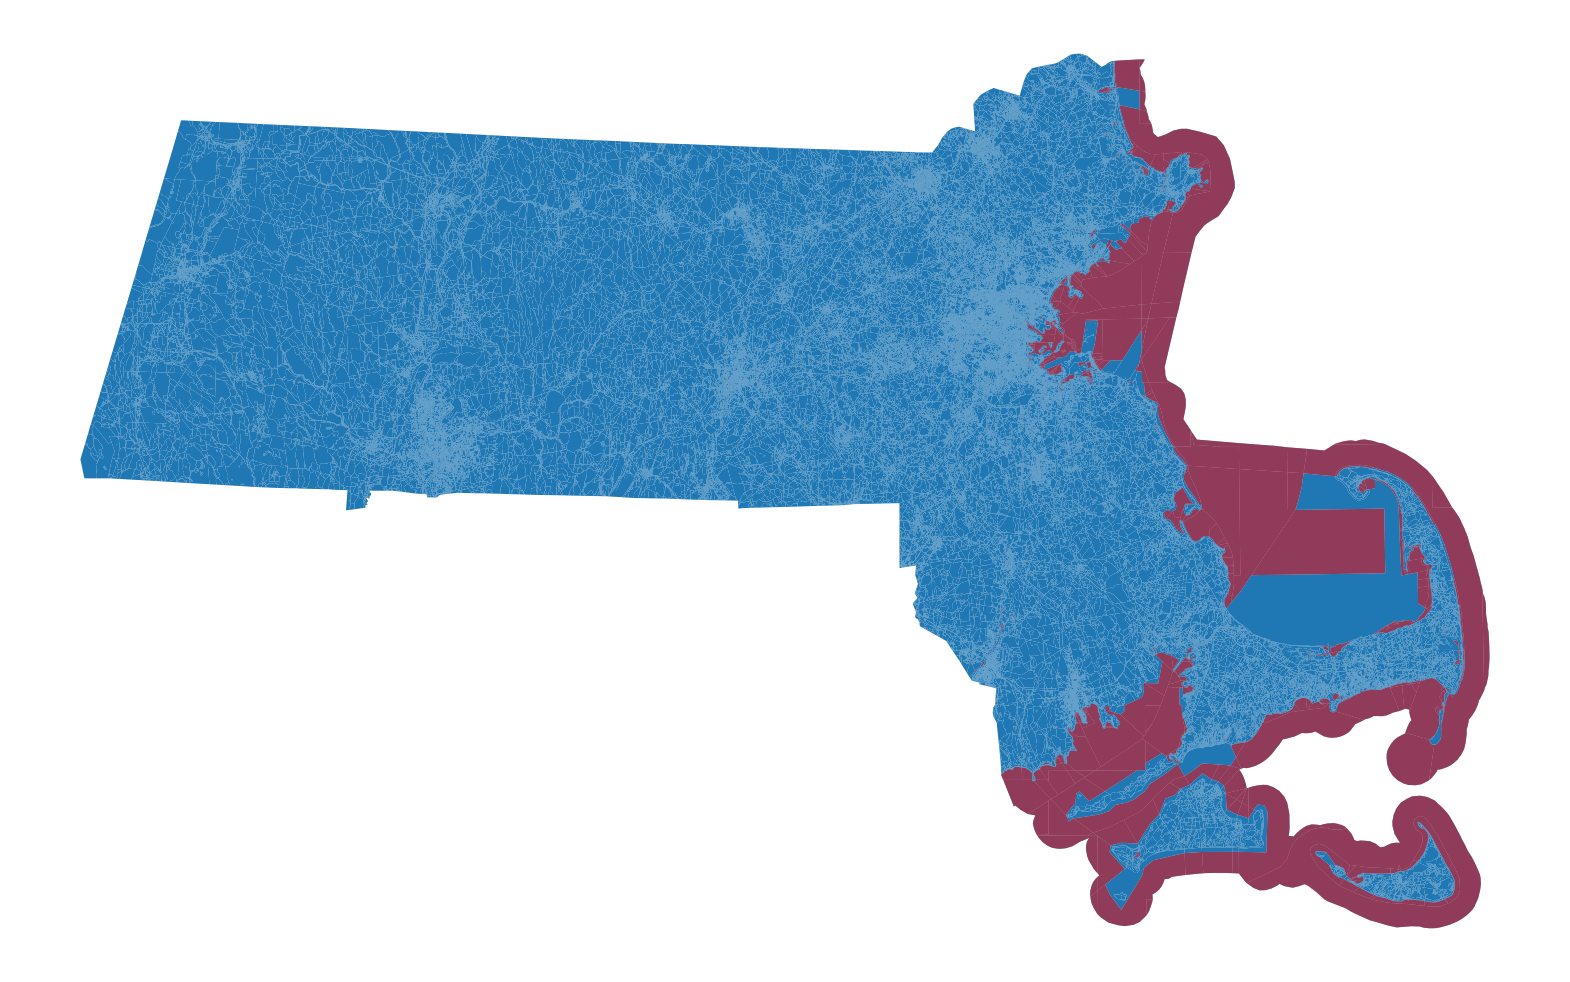

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,20))

ax = ma_2010_census_blocks_gdf.plot(ax=ax)

# The following line takes things that are labeled "na" and colors them red
ax = ma_2010_census_blocks_gdf[ma_2010_census_blocks_gdf["assignment"].isna()].plot(ax=ax, color="red", alpha=0.5)

# The following lines just get rid of the axes and the border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Ah, we might still be okay. It looks like the precinct shapefile that we have does not account
for the census blocks that are over the water. Let's check the population of these blocks and,
so long as they are zero, we're still in business.

In [34]:
# We are going to make a new dataframe that will contain the VAP for each block.
# Note: We are not using the census API for this right now because there appear to
# be some issues with the Census servers not responding to requests for block level
# population data from 2010. Luckily, we have a saved copy of that data that we can use.
census_2010_p3_block_df = pd.read_csv("25_block_2010_P3.csv").set_index("id")
# Convert the index to a string type so that it plays well with the block_to_precinct_assignment
census_2010_p3_block_df.index = census_2010_p3_block_df.index.astype(str)

# Get only the column containing the VAP and convert it to an int
census_2010_p3_block_df = census_2010_p3_block_df[["p003001"]]
census_2010_p3_block_df["p003001"] = census_2010_p3_block_df["p003001"].astype(int)

# Change the name of the column so that it is easier to work with moving forward
census_2010_p3_block_df.rename(columns={"p003001": "VAP"}, inplace=True)
# Identify the rows by their unique geometric identifier
census_2010_p3_block_df.rename_axis("GEOID10", inplace=True)

census_2010_p3_block_df["VAP"].sum()

5128706

In [35]:
census_2010_p3_block_df["assignment"] = block_to_precinct_assignment.astype(str)

# We want the following line to be 0!
census_2010_p3_block_df[census_2010_p3_block_df["assignment"].isna()]["VAP"].sum()

0

Huzzah! The total population of the "na" entries is 0, so we can safely ignore them for this analysis!
Let's now make a filtered dataframe bereft of these bad rows.

In [36]:
# The call ma_2010_census_blocks_gdf["assignment"].isna() returns a boolean series and
# the "~" is the "not" operator. So this bit of code selects all of the rows that are NOT "na"
ma_2010_filtered_block_gdf = ma_2010_census_blocks_gdf.loc[~ma_2010_census_blocks_gdf["assignment"].isna()]

In [37]:
# Let's make a new assignment on the filtered blocks and compare it to the old one just
# to make sure that we didn't mess up any of our data (this is a bit overkill at this point
# but it is good practice to check your data after mucking with it)
new_block_to_precinct_assignment = maup.assign(
    ma_2010_filtered_block_gdf,
    ma_ward_precinct_gdf
)

new_block_to_precinct_assignment.isna().sum()

100%|██████████| 2152/2152 [00:28<00:00, 75.04it/s] 


0

In [38]:
# Sanity-check that the new assignment is the same as the old assignment
all(new_block_to_precinct_assignment == ma_2010_filtered_block_gdf["assignment"])

True

# Getting CVAP and Election Data on Same GDF

Okay! We have election data, we have good block and precinct geometries, now it's time to get
the CVAP data, prorate it down to the block level, and then aggregate it back up to the precincts
so that we can actually do some election analysis.

In [39]:
# Note: these are estimates published by the census
acs5_column_names = {
    "B05003_009E": "Male_Native_CVAP",
    "B05003_011E": "Male_Foreign_Born_Naturalized_CVAP",
    "B05003_020E": "Female_Native_CVAP",
    "B05003_022E": "Female_Foreign_Born_Naturalized_CVAP"
}


acs5_2012_df = pd.DataFrame(census.acs5.get(
    ("B05003_009E", "B05003_011E", "B05003_020E", "B05003_022E"),
    geo={
        "for": "tract:*",
        "in": "state:25"
    },
    year=2012
))


# Get rid of the horrible census column names
acs5_2012_df.rename(columns=acs5_column_names, inplace=True)

acs5_2012_df

,Male_Native_CVAP,Male_Foreign_Born_Naturalized_CVAP,Female_Native_CVAP,Female_Foreign_Born_Naturalized_CVAP,state,county,tract
0,2096.0,117.0,2369.0,138.0,25,009,210500
1,2711.0,129.0,2800.0,73.0,25,009,213100
2,2589.0,56.0,3019.0,103.0,25,009,217100
3,1545.0,26.0,1303.0,15.0,25,009,223200
4,454.0,178.0,438.0,421.0,25,009,250400
...,...,...,...,...,...,...,...
1473,1396.0,66.0,1057.0,111.0,25,017,350900
1474,1395.0,67.0,1323.0,111.0,25,017,353300
1475,1221.0,50.0,1604.0,26.0,25,017,301101
1476,1445.0,120.0,1801.0,185.0,25,017,353600


In [40]:
# Make the CVAP column which is the sum of the columns we are interested in (the values
# in our `acs5_column_names` dictionary)
acs5_2012_df["CVAP"] = acs5_2012_df[list(acs5_column_names.values())].sum(axis=1)

In [41]:
# Standard thing. We need an index that is a unique identifier for the geometry we are interested
# in. Be careful: you need "state", "county", and "tract" together to make a unique key for
# each tract (there are some counties that have the contain tracts with the same tract number)
acs5_2012_df["geo_id"] = acs5_2012_df["state"] + acs5_2012_df["county"] + acs5_2012_df["tract"]
acs5_2012_df.set_index("geo_id", inplace=True)
acs5_2012_df

,Male_Native_CVAP,Male_Foreign_Born_Naturalized_CVAP,Female_Native_CVAP,Female_Foreign_Born_Naturalized_CVAP,state,county,tract,CVAP
geo_id,,,,,,,,
25009210500,2096.0,117.0,2369.0,138.0,25,009,210500,4720.0
25009213100,2711.0,129.0,2800.0,73.0,25,009,213100,5713.0
25009217100,2589.0,56.0,3019.0,103.0,25,009,217100,5767.0
25009223200,1545.0,26.0,1303.0,15.0,25,009,223200,2889.0
25009250400,454.0,178.0,438.0,421.0,25,009,250400,1491.0
...,...,...,...,...,...,...,...,...
25017350900,1396.0,66.0,1057.0,111.0,25,017,350900,2630.0
25017353300,1395.0,67.0,1323.0,111.0,25,017,353300,2896.0
25017301101,1221.0,50.0,1604.0,26.0,25,017,301101,2901.0


In [42]:
# We made a filtered geodataframe earlier, but we never filtered the P3 table, so let's do that now
census_2010_p3_filtered_block_df = census_2010_p3_block_df.loc[~census_2010_p3_block_df["assignment"].isna()]
census_2010_p3_filtered_block_df

,VAP,assignment
GEOID10,,
250010101001000,0,nan
250010101001001,0,Provincetown Ward None Precinct 1
250010101001002,0,Provincetown Ward None Precinct 1
250010101001003,0,Provincetown Ward None Precinct 1
250010101001004,0,Provincetown Ward None Precinct 1
...,...,...
250277614006198,0,Harvard Ward None Precinct 1
250277614006199,0,Harvard Ward None Precinct 1
250277614006200,0,Harvard Ward None Precinct 1


In [43]:
# We are now going to make a new column that will contain the tract-level geo-id for each
# block. Since both track and block are on the central spine of the census geometric hierarchy,
# we can just take the first 11 characters of the block geo-id to get the tract geo-id consistent
# with the geo_id of the acs5_2012_df dataframe
census_2010_p3_filtered_block_df["tract_geo_id"] = census_2010_p3_filtered_block_df.index.map(lambda x: x[:11])
census_2010_p3_filtered_block_df

,VAP,assignment,tract_geo_id
GEOID10,,,
250010101001000,0,nan,25001010100
250010101001001,0,Provincetown Ward None Precinct 1,25001010100
250010101001002,0,Provincetown Ward None Precinct 1,25001010100
250010101001003,0,Provincetown Ward None Precinct 1,25001010100
250010101001004,0,Provincetown Ward None Precinct 1,25001010100
...,...,...,...
250277614006198,0,Harvard Ward None Precinct 1,25027761400
250277614006199,0,Harvard Ward None Precinct 1,25027761400
250277614006200,0,Harvard Ward None Precinct 1,25027761400


In [44]:
block_to_tract_assignment = pd.Series(census_2010_p3_filtered_block_df["tract_geo_id"])


block_vap_values = census_2010_p3_filtered_block_df["VAP"]
p3_tract_level_vap_sums = census_2010_p3_filtered_block_df.groupby("tract_geo_id")["VAP"].sum()

# The next line is a bit tricky. The "map" function will take the values in the
# block_to_tract_assignment series and return the corresponding value in the
# p3_tract_level_sums series
block_tract_vap_values = block_to_tract_assignment.map(p3_tract_level_vap_sums)

prorate_weights = (
    block_vap_values / block_tract_vap_values
).fillna(0)
# The .fillna(0) is just to make sure that we don't have any NaN values

In [45]:
prorated_acs5_2012_blocks = maup.prorate(
    relationship=block_to_tract_assignment,
    data=acs5_2012_df["CVAP"],
    weights=prorate_weights
)

In [46]:
# Sanity check to make sure that the sum of the prorated values is equal to the
# sum of the original values. We don't check if they are exactly equal because
# floating point math can cause small errors
(prorated_acs5_2012_blocks.sum() - acs5_2012_df["CVAP"].sum()) < 0.00001

True

In [47]:
# Now we can add the prorated data to the P3 dataframe
census_2010_p3_filtered_block_df["CVAP"] = prorated_acs5_2012_blocks
precinct_vap_cvap_df = census_2010_p3_filtered_block_df[["VAP", "CVAP", "assignment"]].groupby("assignment").sum()

In [48]:
# Finally we add the VAP and CVAP data onto our Precinct geodataframe
ma_ward_precinct_gdf["VAP"] = precinct_vap_cvap_df["VAP"]
ma_ward_precinct_gdf["CVAP"] = precinct_vap_cvap_df["CVAP"]
ma_ward_precinct_gdf

,TOWN,WARD,PRECINCT,VTD,geometry,Dem Votes,Rep Votes,Total Votes,VAP,CVAP
Name,,,,,,,,,,
Braintree Ward None Precinct 5B,Braintree,None,5B,5B,"POLYGON ((242364.517 883741.979, 242359.642 88...",857,851,1737,2229,1961.845304
Braintree Ward None Precinct 6A,Braintree,None,6A,6A,"POLYGON ((243479.798 881994.897, 243477.538 88...",916,1035,1981,2425,2358.997906
Braintree Ward None Precinct 6B,Braintree,None,6B,6B,"POLYGON ((241614.364 881551.551, 241602.936 88...",862,823,1729,2160,2073.630976
Chelsea Ward 1 Precinct 1,Chelsea,1,1,1-1,"POLYGON ((239281.036 904133.287, 239277.513 90...",410,93,515,1689,830.848308
Chelsea Ward 1 Precinct 2,Chelsea,1,2,1-2,"POLYGON ((238408.578 904480.138, 238393.140 90...",255,36,305,1468,580.286734
...,...,...,...,...,...,...,...,...,...,...
Boston Ward 7 Precinct 8,Boston,7,8,7-8,"POLYGON ((236328.257 897806.825, 236339.793 89...",468,191,690,1487,1146.064281
Boston Ward 12 Precinct 3,Boston,12,3,12-3,"POLYGON ((234387.165 896770.015, 234357.873 89...",713,16,734,853,641.376680
Boston Ward 12 Precinct 2,Boston,12,2,12-2,"POLYGON ((234109.165 896499.623, 234101.151 89...",1406,13,1425,2361,2232.185065


Amazing! Now we can take a look at some of the Democratic Votes data next to
the CVAP data.

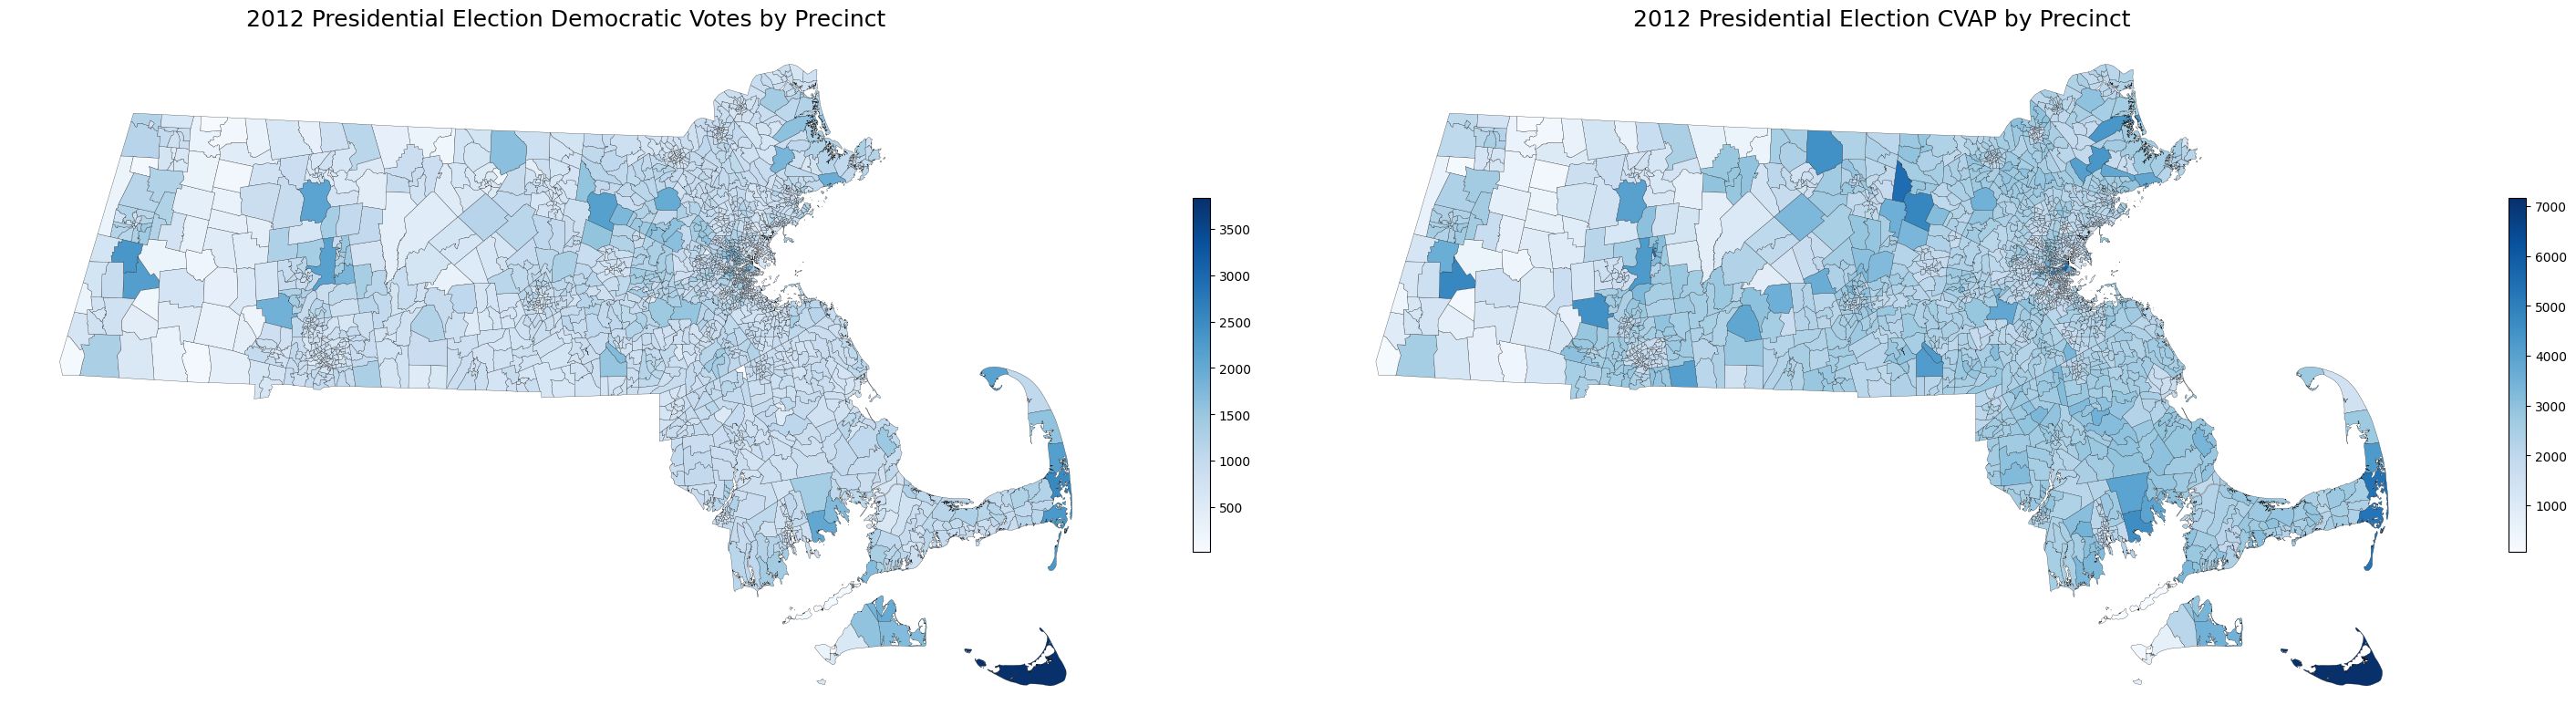

In [49]:
fig, ax = plt.subplots(1,2,figsize=(30, 10))
ax[0].axis('off')
ax[0].set_title("2012 Presidential Election Democratic Votes by Precinct", fontsize=18)
ma_ward_precinct_gdf.plot(
    ax=ax[0],
    column="Dem Votes",
    vmin=min(ma_ward_precinct_gdf["Dem Votes"]),
    vmax=max(ma_ward_precinct_gdf["Dem Votes"]),
    **choropleth_style,
)

ax[1].axis('off')
ax[1].set_title("2012 Presidential Election CVAP by Precinct", fontsize=18)
ma_ward_precinct_gdf.plot(
    ax=ax[1],
    column="CVAP",
    vmin=min(ma_ward_precinct_gdf["CVAP"]),
    vmax=max(ma_ward_precinct_gdf["CVAP"]),
    **choropleth_style,
)
plt.tight_layout()
plt.show()


# Your Task

Now that we have CVAP and some election data on the same geographies, you now need to compute
voter turnout as a share of CVAP.